# Random Forests Method for the January Tabular Data Challenge
## Step 1. Building the Model

In [32]:
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display
import pandas as pd
import numpy as np
import holidays

random_state = 3165
store_data = pd.read_csv("data/train.csv", index_col='date', parse_dates=True)
display(store_data.head())
display(store_data.tail())

,row_id,country,store,product,num_sold
date,,,,,
2015-01-01,0,Finland,KaggleMart,Kaggle Mug,329
2015-01-01,1,Finland,KaggleMart,Kaggle Hat,520
2015-01-01,2,Finland,KaggleMart,Kaggle Sticker,146
2015-01-01,3,Finland,KaggleRama,Kaggle Mug,572
2015-01-01,4,Finland,KaggleRama,Kaggle Hat,911


,row_id,country,store,product,num_sold
date,,,,,
2018-12-31,26293,Sweden,KaggleMart,Kaggle Hat,823
2018-12-31,26294,Sweden,KaggleMart,Kaggle Sticker,250
2018-12-31,26295,Sweden,KaggleRama,Kaggle Mug,1004
2018-12-31,26296,Sweden,KaggleRama,Kaggle Hat,1441
2018-12-31,26297,Sweden,KaggleRama,Kaggle Sticker,388


In [33]:
split_date = '2017-12-31'
store_data_train = store_data.loc[store_data.index <= split_date].copy()
store_data_val = store_data.loc[store_data.index > split_date].copy()

In [34]:
def create_time_features(df: pd.DataFrame):
    """
    Author: Rob Mulla, Robin Onsay
    link: https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost
    :param df:
    :return:
    """
    date_key = 'date'
    df[date_key] = df.index
    df['dayofweek'] = df[date_key].dt.dayofweek
    df['quarter'] = df[date_key].dt.quarter
    df['month'] = df[date_key].dt.month
    df['year'] = df[date_key].dt.year
    df['day_of_year'] = df[date_key].dt.dayofyear
    df['day_of_month'] = df[date_key].dt.day
    df['week_of_year'] = np.int64(df[date_key].dt.isocalendar().week)
    is_holiday = lambda x: (x[date_key] in holidays.CountryHoliday(x['country']))
    df['is_holiday'] = df.apply(is_holiday, axis=1)
    df['is_month_start'] = df[date_key].dt.is_month_start
    df['is_month_end'] = df[date_key].dt.is_month_end
    df['is_quarter_start'] = df[date_key].dt.is_quarter_start
    df['is_quarter_end'] = df[date_key].dt.is_quarter_end
    df['is_year_start'] = df[date_key].dt.is_year_start
    df['is_year_end'] = df[date_key].dt.is_year_end
    df['is_leap_year'] = df[date_key].dt.is_leap_year
    return ['dayofweek', 'quarter',
            'month', 'year',
            'day_of_year', 'day_of_month',
            'week_of_year', 'is_holiday',
            'is_month_start', 'is_month_end',
            'is_quarter_start', 'is_quarter_end',
            'is_year_start', 'is_year_end',
            'is_leap_year']

In [35]:
time_features = create_time_features(store_data_train)
_ = create_time_features(store_data_val)

In [36]:
features = time_features + ['country', 'store', 'product']
X_train = store_data_train[features]
y_train = store_data_train.num_sold
X_val = store_data_val[features]
y_val = store_data_val.num_sold
display(X_train.head())

,dayofweek,quarter,month,year,day_of_year,day_of_month,week_of_year,is_holiday,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year,country,store,product
date,,,,,,,,,,,,,,,,,,
2015-01-01,3,1,1,2015,1,1,1,True,True,False,True,False,True,False,False,Finland,KaggleMart,Kaggle Mug
2015-01-01,3,1,1,2015,1,1,1,True,True,False,True,False,True,False,False,Finland,KaggleMart,Kaggle Hat
2015-01-01,3,1,1,2015,1,1,1,True,True,False,True,False,True,False,False,Finland,KaggleMart,Kaggle Sticker
2015-01-01,3,1,1,2015,1,1,1,True,True,False,True,False,True,False,False,Finland,KaggleRama,Kaggle Mug
2015-01-01,3,1,1,2015,1,1,1,True,True,False,True,False,True,False,False,Finland,KaggleRama,Kaggle Hat


In [37]:
def one_hot_encode(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_df = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]))
    OH_df.index = df.index
    num_cols = df.drop(object_cols, axis=1)
    df = pd.concat([num_cols, OH_df], axis=1)
    df.columns = df.columns.astype(str)
    return df

In [38]:
X_train = one_hot_encode(X_train)
X_val = one_hot_encode(X_val)
display(X_train)

,dayofweek,quarter,month,year,day_of_year,day_of_month,week_of_year,is_holiday,is_month_start,is_month_end,...,is_year_end,is_leap_year,0,1,2,3,4,5,6,7
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,3,1,1,2015,1,1,1,True,True,False,...,False,False,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2015-01-01,3,1,1,2015,1,1,1,True,True,False,...,False,False,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2015-01-01,3,1,1,2015,1,1,1,True,True,False,...,False,False,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2015-01-01,3,1,1,2015,1,1,1,True,True,False,...,False,False,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2015-01-01,3,1,1,2015,1,1,1,True,True,False,...,False,False,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,6,4,12,2017,365,31,52,True,False,True,...,True,False,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2017-12-31,6,4,12,2017,365,31,52,True,False,True,...,True,False,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2017-12-31,6,4,12,2017,365,31,52,True,False,True,...,True,False,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## Step 2. Train the Model

Best Iteration: 8143


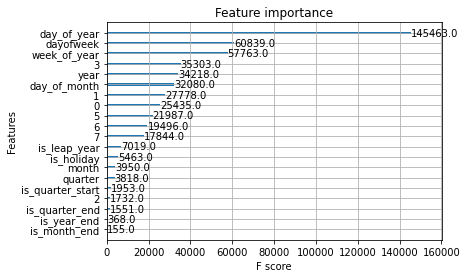

In [39]:
learning_rate = 0.001
forest_model = XGBRegressor(n_estimators=10000,
                            learning_rate=learning_rate,
                            random_state=random_state)
forest_model.fit(X_train, y_train,
                 early_stopping_rounds=50,
                 eval_set=[(X_val, y_val)],
                 verbose=False)
_ = plot_importance(forest_model)
predictions = forest_model.predict(X_val)
best_iteration = forest_model.best_iteration
print(f"Best Iteration: {best_iteration}")

## Step 3. Validate the Model

In [40]:
def smape(A, F):
    """
    Thanks https://stackoverflow.com/questions/51444630/how-to-use-smape-evaluation-metric-on-train-dataset and https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    """
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

print(f"SMAPE: {smape(y_val, predictions)}")

SMAPE: 8.38844397093626


## Step 4. Choose/Train the Complete Model

In [41]:
forest_model = XGBRegressor(n_estimators=best_iteration,
                            learning_rate=learning_rate,
                            random_state=random_state)
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)
forest_model.fit(X, y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=8143, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=3165,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Step 5. Predict Test Values

In [42]:
test_df = pd.read_csv("data/test.csv", index_col='date', parse_dates=True)
display(test_df.head())
_ = create_time_features(test_df)

,row_id,country,store,product
date,,,,
2019-01-01,26298,Finland,KaggleMart,Kaggle Mug
2019-01-01,26299,Finland,KaggleMart,Kaggle Hat
2019-01-01,26300,Finland,KaggleMart,Kaggle Sticker
2019-01-01,26301,Finland,KaggleRama,Kaggle Mug
2019-01-01,26302,Finland,KaggleRama,Kaggle Hat


In [43]:
test_X = test_df[features]
test_X = one_hot_encode(test_X)
display(test_X.head())

,dayofweek,quarter,month,year,day_of_year,day_of_month,week_of_year,is_holiday,is_month_start,is_month_end,...,is_year_end,is_leap_year,0,1,2,3,4,5,6,7
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,1,1,2019,1,1,1,True,True,False,...,False,False,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2019-01-01,1,1,1,2019,1,1,1,True,True,False,...,False,False,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2019-01-01,1,1,1,2019,1,1,1,True,True,False,...,False,False,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2019-01-01,1,1,1,2019,1,1,1,True,True,False,...,False,False,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2019-01-01,1,1,1,2019,1,1,1,True,True,False,...,False,False,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [44]:
predictions = np.round(forest_model.predict(test_X))
test_df['num_sold'] = np.int64(predictions)
output = test_df.set_index('row_id')['num_sold']
display(output)
output.to_csv('predictions/xgboost_predictions.csv')

row_id
26298     399
26299     604
26300     178
26301     692
26302    1036
Name: num_sold, dtype: int64